In [ ]:
"""
seleccion:
    'elitist'
    'roulette_wheel'
    'boltzmann'  usa pseudo-performance roulette_wheel
    'universal_selection'   
    'deterministic_tournament'
    'stochastic_tournament'
    'rank_based'    usa pseudo-performance roulette_wheel

crossover:
    'one_point'
    'two_point'
    'uniform'
    'annular'

mutation:
    'one_gene'
    'multi_gene'
    'multi_gene_mutation_uniform'
"""

#### Setup

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.8e}'.format

import configparser
from collections import defaultdict
from src.character import Character, CharacterType 
from src.stats import random_stats
from src.genes import  encode_genes, decode_genes
from src.mutation import one_gene_mutation, multi_gene_mutation, multi_gene_mutation_uniform

import sys
sys.path.append("src")

from src.population import generate_init_population, eval_performace
from src.selection import stochastic_tournament_selection, deterministic_tournament_selection, add_relative_accumulate, elitist_selection, roulette_wheel_selection, universal_selection, boltzmann_selection, rank_based_selection
from src.crossover import single_point_crossover, two_point_crossover, uniform_crossover, annular_crossover, normalize_chromosome


In [3]:
from collections import namedtuple

def read_config(filename):
    config = configparser.ConfigParser()
    config.read(filename)
    params = defaultdict(dict)
    for section in config.sections():
        for key, value in config.items(section):
            params[section][key] = value
    return params

#params = read_config('config_file.config')

def parameters():
    
    config_params = read_config('config_file.config')

    # Personaje 
    type = eval(config_params['CHARACTER']['type'])
    
    # sum( stats ) = 150
    maxStatsValue = eval(config_params['M']['m'])
    
    # N
    populationNumber = eval(config_params['N']['n'])
    # K
    k = eval(config_params['K']['k'])

    # Numero máximo de generaciones - criterio de corte
    numberOfGenerations = eval(config_params['GENERATIONS']['number'])
    
    # A%
    method1Percentage = eval(config_params['METHOD1PERCENTAGE']['percentage'])
    selectionMethod1 = eval(config_params['SELECTION_METHOD']['method1'])
    selectionMethod2 = eval(config_params['SELECTION_METHOD']['method2'])
   
    # CrossOver
    metodo_cruza = eval(config_params['metodo_cruza']['crossover'])
 
    # Mutation
    mutation_type = eval(config_params['MUTATION']['mutation_type'])
    mutation_rate = eval(config_params['MUTATION']['mutation_rate'])

    # B%
    methodReplacePercentage = eval(config_params['METHODRePERCENTAGE']['percentage'])
    metodo_reemplazo3 = eval(config_params['metodo_reemplazo']['metodo1'])
    metodo_reemplazo4 = eval(config_params['metodo_reemplazo']['metodo2'])

    cutCriteria = eval(config_params['CUT_CRITERIA']['criteria_type'])
    
    # Selector parameters
    # M
    tournament_size = eval(config_params['deterministic_tournament_selection']['tournament_size'])
    # stochastic_tournament_selection
    threhold = eval(config_params['stochastic_tournament_selection']['threshold'])
    # Boltzmann parameters
    boltzmannT_0 = eval(config_params['BOLTZMANN']['t_0'])
    boltzmannT_c = eval(config_params['BOLTZMANN']['t_c'])
    boltzmannM = eval(config_params['BOLTZMANN']['m'])

    Param = namedtuple('Param',[
        'character',
        'maxStatsValue',
        'populationNumber',
        'k',
        'numberOfGenerations',
        'method1Percentage',
        'selectionMethod1',
        'selectionMethod2',
        'metodo_cruza',
        'mutation_type',
        'mutation_rate',
        'methodReplacePercentage',
        'metodo_reemplazo3',
        'metodo_reemplazo4',
        'cutCriteria',
        'tournament_size',
        'threhold',
        'boltzmannT_0',
        'boltzmannT_c',
        'boltzmannM'
    ])    

    parametros = Param(
                character=type,
                maxStatsValue=maxStatsValue,
                populationNumber=populationNumber,
                k=k,
                numberOfGenerations=numberOfGenerations,
                method1Percentage=method1Percentage,
                selectionMethod1=selectionMethod1,
                selectionMethod2=selectionMethod2,
                metodo_cruza=metodo_cruza,
                mutation_type=mutation_type,
                mutation_rate=mutation_rate,
                methodReplacePercentage=methodReplacePercentage,
                metodo_reemplazo3=metodo_reemplazo3,
                metodo_reemplazo4=metodo_reemplazo4,
                cutCriteria=cutCriteria,
                tournament_size=tournament_size,
                threhold=threhold,
                boltzmannT_0=boltzmannT_0,
                boltzmannT_c=boltzmannT_c,
                boltzmannM=boltzmannM
    )

    return parametros

#p = parameters()


In [ ]:
"""
from src.character import Character, CharacterType 
import sys
sys.path.append("src")

from src.population import generate_init_population

#GENERACION 0

generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)
generacion = 0
"""


In [ ]:
"""
# GUARDO EL MAS APTO DE LA GENERACION 0
# Escribe la poblacion inicial.
#generation_0.insert(0, 'generation', int(generacion))
generation_0['generation'] = generacion
mas_apto_G0 = generation_0.head(1)
mas_apto_G0.to_csv(f'datos-Prueba1.csv', mode='w', index=False)
"""


#### Functions

In [ ]:

def method_selector(Kt, method1Percentage): 
    # Selecciono K individuos
    # Utilizo el porcentaje para cada método
    K1 = int(np.round(Kt * method1Percentage))
    K2 = Kt - K1
    return K1, K2

#k1, k2 = method_selector(p.k, p.method1Percentage)

In [ ]:
#current_generation = generation_0
#generacion = 0

In [ ]:
def selection_method(poblacion, ki, params, method, generation):

    if(method == 'elitist'):
        selected = elitist_selection(poblacion, ki)
    elif(method == 'roulette_wheel'):
        selected = roulette_wheel_selection(poblacion, ki)
    elif(method == 'boltzmann'):
        selected = boltzmann_selection(poblacion, ki, generation, params.boltzmannT_0,params.boltzmannT_c,params.boltzmannM)
    elif(method == 'universal_selection'):
        selected = universal_selection(poblacion, ki)
    elif(method == 'deterministic_tournament'):
        selected = deterministic_tournament_selection(poblacion, params.tournament_size, ki)
    elif(method == 'stochastic_tournament'):
        selected = stochastic_tournament_selection(poblacion, ki, params.threhold)
    elif(method == 'rank_based'):
        selected = rank_based_selection(poblacion, ki)
    return selected
"""
# SELECCION DE PADRES
generacion_sel1 = selection_method(current_generation, k1, p, p.selectionMethod1, generacion)
generacion_sel2 = selection_method(current_generation, k2, p, p.selectionMethod2, generacion)

# SELECCION TOTAL: K padres
selection_total = pd.concat([generacion_sel1, generacion_sel2])

selection_total.drop(columns=['performance_relative'], inplace=True)
selection_total.drop(columns=['performance_accumulated'], inplace=True)
selection_total = selection_total.sort_values(by='performance', ascending=False)
selection_total.reset_index(drop=True, inplace=True)
"""


In [ ]:
#cromosomas = encode_genes(selection_total)

#cromosomas

In [ ]:
def crossover_method(poblacion, method):
    
    if(method == 'one_point'):
        crossed = single_point_crossover(poblacion)
    elif(method == 'two_point'):
        crossed = two_point_crossover(poblacion)
    elif(method == 'uniform'):
        crossed = uniform_crossover(poblacion)
    elif(method == 'annular'):
        crossed = annular_crossover(poblacion)
    
    return crossed

#crossed_result = crossover_method(cromosomas, p.metodo_cruza)

#crossed_result

In [ ]:
def mutation_method(poblacion, rate, method):
    
    if(method == 'one_gene'):
        mutated = one_gene_mutation(poblacion, rate)
    elif(method == 'multi_gene'):
        mutated = multi_gene_mutation(poblacion, rate)
    elif(method == 'multi_gene_mutation_uniform'):
        mutated = multi_gene_mutation_uniform(poblacion, rate)
    
    return mutated

#mutation_result = mutation_method(crossed_result, p.mutation_rate, p.mutation_type)

#mutation_result

In [ ]:
#cromosomas_norm = normalize_chromosome(mutation_result)

#cromosomas_norm

In [ ]:
"""
cromosomas_norm_decode = decode_genes(cromosomas_norm)
offspring = eval_performace(cromosomas_norm_decode,p.character)

offspring = offspring.sort_values(by='performance', ascending=False)
offspring.reset_index(drop=True, inplace=True)

offspring

"""

In [ ]:
"""
# REEMPLAZO
# padres:  selection_total de tamaño K
# hijos: offspring  de tamaño K
# tomo K de los hijos
k_reemplazo_metodo3 = p.k
# el resto para completar N
k_reemplazo_metodo4 = p.populationNumber - p.k

# SELECCION DE PADRES
generacion_reemp1 = selection_method(offspring, k_reemplazo_metodo3, p, p.metodo_reemplazo3, generacion)
generacion_reemp2 = selection_method(selection_total, k_reemplazo_metodo4, p, p.metodo_reemplazo4, generacion)

# SELECCION TOTAL: K padres
new_generation = pd.concat([generacion_reemp1, generacion_reemp2])

new_generation.drop(columns=['performance_relative'], inplace=True)
new_generation.drop(columns=['performance_accumulated'], inplace=True)
new_generation = new_generation.sort_values(by='performance', ascending=False)
new_generation.reset_index(drop=True, inplace=True)

new_generation
"""

In [ ]:
"""
generacion += 1
# GUARDO EL MAS APTO DE LA GENERACION NUEVA
# Escribe la poblacion inicial.

#new_generation.insert(0, 'generation', int(generacion))
new_generation['generation'] = generacion
mas_apto_NG = new_generation.head(1)
mas_apto_NG.to_csv(f'datos-Prueba1.csv', mode='a', header=False, index=False)
"""

#### Selections

In [4]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

generation_0.to_csv(f'generation0.csv', mode='w', index=False)
generation_0

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,50,14,75,2,9,1.70000000e+00,CharacterType.ARCHER,9.66596785e+02
1,69,2,46,19,14,1.70000000e+00,CharacterType.ARCHER,8.24511225e+02
2,76,6,40,21,7,2.00000000e+00,CharacterType.ARCHER,8.11671774e+02
3,37,46,54,10,3,1.80000000e+00,CharacterType.ARCHER,6.52235793e+02
4,31,30,61,1,27,1.60000000e+00,CharacterType.ARCHER,5.71413252e+02
...,...,...,...,...,...,...,...,...
75,4,17,16,112,1,1.40000000e+00,CharacterType.ARCHER,2.40926193e+01
76,6,38,1,7,98,1.70000000e+00,CharacterType.ARCHER,1.44749803e+01
77,2,45,12,76,15,1.30000000e+00,CharacterType.ARCHER,1.42983881e+01
78,3,2,10,110,25,1.50000000e+00,CharacterType.ARCHER,1.35437062e+01


In [5]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

elitist_selection = elitist_selection(generation_0,p.k)
elitist_selection.to_csv(f'elitist_selection.csv', mode='w', index=False)

elitist_selection

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,52,15,54,19,10,1.40000000e+00,CharacterType.ARCHER,7.95484132e+02
1,67,14,36,29,4,1.90000000e+00,CharacterType.ARCHER,7.22249588e+02
2,63,15,36,30,6,1.80000000e+00,CharacterType.ARCHER,6.74247002e+02
3,54,5,44,34,13,1.40000000e+00,CharacterType.ARCHER,6.70072016e+02
4,60,43,28,17,2,1.80000000e+00,CharacterType.ARCHER,5.96157028e+02
5,66,23,28,1,32,1.60000000e+00,CharacterType.ARCHER,5.72236468e+02
6,77,13,23,13,24,1.90000000e+00,CharacterType.ARCHER,5.39015183e+02
7,60,35,24,3,28,1.90000000e+00,CharacterType.ARCHER,5.27376406e+02
8,26,31,68,22,3,1.60000000e+00,CharacterType.ARCHER,5.15693475e+02
9,29,6,61,21,33,1.50000000e+00,CharacterType.ARCHER,5.12998936e+02


In [6]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

roulette_wheel_selection = roulette_wheel_selection(generation_0,p.k)
roulette_wheel_selection.to_csv(f'roulette_wheel_selection.csv', mode='w', index=False)

roulette_wheel_selection

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,53,33,29,27,8,1.40000000e+00,CharacterType.ARCHER,5.22736363e+02
1,51,22,15,9,53,1.50000000e+00,CharacterType.ARCHER,2.83777657e+02
2,35,3,93,1,18,1.40000000e+00,CharacterType.ARCHER,8.00759393e+02
3,57,7,57,26,3,1.60000000e+00,CharacterType.ARCHER,8.57442327e+02
4,35,3,93,1,18,1.40000000e+00,CharacterType.ARCHER,8.00759393e+02
5,25,18,48,8,51,1.70000000e+00,CharacterType.ARCHER,3.83617568e+02
6,11,4,63,47,25,1.70000000e+00,CharacterType.ARCHER,2.06349168e+02
7,72,4,39,9,26,1.90000000e+00,CharacterType.ARCHER,7.85477564e+02
8,35,44,19,18,34,1.40000000e+00,CharacterType.ARCHER,2.81076355e+02
9,53,33,29,27,8,1.40000000e+00,CharacterType.ARCHER,5.22736363e+02


In [7]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
max_generations = p.numberOfGenerations
print(f'max_generations = {p.numberOfGenerations}')

# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

# Example BOLTZMANN


max_generation = p.numberOfGenerations
generation = 3
k = p.k                                 # Number of desired selected individuals.
T_0 = p.boltzmannT_0                                # Initial temperature.
T_c = p.boltzmannT_c                          # Offset value for temperature exponential function.
#reference_generation = max_generation   # Reference generation where 0 < (T_0 - T_offset) = 0.015 = deltaT is desired.
#deltaT = 0.015                          # 0 < (T_0 - T_offset) = deltaT at reference generation.
#m = - (np.log(deltaT) - np.log(T_0 - T_offset)) / reference_generation
m = p.boltzmannM
print(f'T_0= {T_0}')
print(f'T_c= {T_c}')
print(f'm= {m}')

new_boltzmann_selection = boltzmann_selection(generation_0,k,generation,T_0,T_c,m)

#new_boltzmann_selection = boltzmann_selection(generation_0,60,3,T_0,T_c,m)

new_boltzmann_selection.to_csv(f'boltzmann_selection.csv', mode='w', index=False)
new_boltzmann_selection

N = 80
K = 60
max_generations = 200
T_0= 50
T_c= 2
m= 0.02


,strength,agility,expertise,resistance,life,height,characterType,performance
0,73,14,43,18,2,1.90000000e+00,CharacterType.ARCHER,8.94271004e+02
1,73,14,43,18,2,1.90000000e+00,CharacterType.ARCHER,8.94271004e+02
2,73,14,43,18,2,1.90000000e+00,CharacterType.ARCHER,8.94271004e+02
3,73,14,43,18,2,1.90000000e+00,CharacterType.ARCHER,8.94271004e+02
4,73,14,43,18,2,1.90000000e+00,CharacterType.ARCHER,8.94271004e+02
5,73,14,43,18,2,1.90000000e+00,CharacterType.ARCHER,8.94271004e+02
6,73,14,43,18,2,1.90000000e+00,CharacterType.ARCHER,8.94271004e+02
7,73,14,43,18,2,1.90000000e+00,CharacterType.ARCHER,8.94271004e+02
8,73,14,43,18,2,1.90000000e+00,CharacterType.ARCHER,8.94271004e+02
9,73,14,43,18,2,1.90000000e+00,CharacterType.ARCHER,8.94271004e+02


In [8]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

universal_selection = universal_selection(generation_0,p.k)

universal_selection.to_csv(f'universal_selection.csv', mode='w', index=False)
universal_selection

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,54,25,56,3,12,1.80000000e+00,CharacterType.ARCHER,8.85158460e+02
1,54,25,56,3,12,1.80000000e+00,CharacterType.ARCHER,8.85158460e+02
2,54,25,56,3,12,1.80000000e+00,CharacterType.ARCHER,8.85158460e+02
3,58,18,51,19,4,1.40000000e+00,CharacterType.ARCHER,8.37554978e+02
4,58,18,51,19,4,1.40000000e+00,CharacterType.ARCHER,8.37554978e+02
5,58,18,51,19,4,1.40000000e+00,CharacterType.ARCHER,8.37554978e+02
6,52,9,57,5,27,1.60000000e+00,CharacterType.ARCHER,8.08315159e+02
7,52,9,57,5,27,1.60000000e+00,CharacterType.ARCHER,8.08315159e+02
8,57,13,40,29,11,1.60000000e+00,CharacterType.ARCHER,6.55605040e+02
9,57,13,40,29,11,1.60000000e+00,CharacterType.ARCHER,6.55605040e+02


In [9]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

deterministic_tournament = deterministic_tournament_selection(generation_0,p.tournament_size,p.k)

deterministic_tournament.to_csv(f'deterministic_tournament.csv', mode='w', index=False)
deterministic_tournament

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,41,39,15,47,8,1.60000000e+00,CharacterType.ARCHER,2.59385944e+02
1,3,41,84,10,12,1.80000000e+00,CharacterType.ARCHER,7.82103086e+01
2,5,83,20,31,11,1.50000000e+00,CharacterType.ARCHER,5.15099867e+01
3,66,2,45,33,4,1.60000000e+00,CharacterType.ARCHER,7.76702861e+02
4,5,83,20,31,11,1.50000000e+00,CharacterType.ARCHER,5.15099867e+01
5,23,28,50,38,11,1.50000000e+00,CharacterType.ARCHER,3.71510219e+02
6,13,30,14,48,45,2.00000000e+00,CharacterType.ARCHER,8.39973136e+01
7,14,27,31,64,14,1.90000000e+00,CharacterType.ARCHER,1.63001050e+02
8,11,9,97,13,20,1.50000000e+00,CharacterType.ARCHER,2.77945437e+02
9,54,10,13,65,8,1.40000000e+00,CharacterType.ARCHER,2.31465014e+02


In [10]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

stochastic_tournament_selection = stochastic_tournament_selection(generation_0, p.k, p.threhold)

stochastic_tournament_selection.to_csv(f'stochastic_tournament_selection.csv', mode='w', index=False)
stochastic_tournament_selection

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,38,26,43,20,23,1.60000000e+00,CharacterType.ARCHER,5.18862114e+02
1,6,76,33,28,7,1.30000000e+00,CharacterType.ARCHER,7.67249668e+01
2,59,48,3,2,38,2.00000000e+00,CharacterType.ARCHER,1.79905382e+02
3,65,12,9,58,6,1.40000000e+00,CharacterType.ARCHER,2.01441810e+02
4,6,14,3,12,115,2.00000000e+00,CharacterType.ARCHER,1.27725975e+01
5,6,76,33,28,7,1.30000000e+00,CharacterType.ARCHER,7.67249668e+01
6,28,19,46,20,37,2.00000000e+00,CharacterType.ARCHER,4.17787209e+02
7,4,4,121,14,7,1.50000000e+00,CharacterType.ARCHER,1.11931918e+02
8,34,38,15,21,42,1.40000000e+00,CharacterType.ARCHER,2.24206200e+02
9,35,22,2,36,55,1.30000000e+00,CharacterType.ARCHER,5.87040929e+01


In [11]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

rank_based_selection1 = rank_based_selection(generation_0, p.k)

rank_based_selection1.to_csv(f'rank_based_selection.csv', mode='w', index=False)
rank_based_selection1

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,21,6,2,76,45,1.90000000e+00,CharacterType.ARCHER,9.37500000e-01
1,1,13,34,73,29,1.90000000e+00,CharacterType.ARCHER,9.50000000e-01
2,6,28,1,45,70,1.70000000e+00,CharacterType.ARCHER,9.75000000e-01
3,6,73,25,10,36,1.40000000e+00,CharacterType.ARCHER,8.62500000e-01
4,6,73,25,10,36,1.40000000e+00,CharacterType.ARCHER,8.62500000e-01
5,10,55,16,68,1,1.70000000e+00,CharacterType.ARCHER,8.37500000e-01
6,21,6,2,76,45,1.90000000e+00,CharacterType.ARCHER,9.37500000e-01
7,50,17,7,15,61,1.30000000e+00,CharacterType.ARCHER,7.00000000e-01
8,26,63,13,24,24,1.40000000e+00,CharacterType.ARCHER,6.00000000e-01
9,10,22,19,30,69,1.50000000e+00,CharacterType.ARCHER,8.25000000e-01


#### Crossover

In [12]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0)
crossover_individuals1 = single_point_crossover(cromosomas1)
cromosomas_norm1 = normalize_chromosome(crossover_individuals1)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
crossover_individuals1 = eval_performace(cromosomas_decod1, p.character)
crossover_individuals1 = crossover_individuals1.sort_values(by='performance', ascending=False)
crossover_individuals1.reset_index(drop=True, inplace=True)

crossover_individuals1.to_csv(f'single_point_crossover.csv', mode='w', index=False)

#crossover_individuals1

N = 80
K = 60


In [13]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0)
crossover_individuals1 = two_point_crossover(cromosomas1)
cromosomas_norm1 = normalize_chromosome(crossover_individuals1)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
crossover_individuals1 = eval_performace(cromosomas_decod1, p.character)
crossover_individuals1 = crossover_individuals1.sort_values(by='performance', ascending=False)
crossover_individuals1.reset_index(drop=True, inplace=True)

crossover_individuals1.to_csv(f'two_point_crossover.csv', mode='w', index=False)

#crossover_individuals1

N = 80
K = 60


In [14]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0)
crossover_individuals1 = annular_crossover(cromosomas1)
cromosomas_norm1 = normalize_chromosome(crossover_individuals1)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
crossover_individuals1 = eval_performace(cromosomas_decod1, p.character)
crossover_individuals1 = crossover_individuals1.sort_values(by='performance', ascending=False)
crossover_individuals1.reset_index(drop=True, inplace=True)

crossover_individuals1.to_csv(f'annular_crossover.csv', mode='w', index=False)

#crossover_individuals1

N = 80
K = 60


In [15]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0u = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0u)

crossover_individuals1u = uniform_crossover(cromosomas1)
cromosomas_norm1 = normalize_chromosome(crossover_individuals1u)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
crossover_individuals1 = eval_performace(cromosomas_decod1, p.character)
crossover_individuals1 = crossover_individuals1.sort_values(by='performance', ascending=False)
crossover_individuals1.reset_index(drop=True, inplace=True)

crossover_individuals1.to_csv(f'uniform_crossover.csv', mode='w', index=False)

crossover_individuals1

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,5.50000000e+01,1.30000000e+01,6.00000000e+01,1.00000000e+00,1.80000000e+01,1.90000000e+00,CharacterType.ARCHER,9.40651272e+02
1,5.30000000e+01,1.00000000e+00,5.70000000e+01,8.00000000e+00,2.90000000e+01,2.00000000e+00,CharacterType.ARCHER,8.22042147e+02
2,3.80000000e+01,4.00000000e+00,7.90000000e+01,6.00000000e+00,2.30000000e+01,1.70000000e+00,CharacterType.ARCHER,7.73659089e+02
3,3.70000000e+01,2.00000000e+00,7.40000000e+01,1.00000000e+01,2.40000000e+01,1.50000000e+00,CharacterType.ARCHER,7.27548335e+02
4,5.90000000e+01,6.00000000e+00,4.20000000e+01,5.00000000e+00,3.50000000e+01,1.50000000e+00,CharacterType.ARCHER,7.00035712e+02
...,...,...,...,...,...,...,...,...
75,0.00000000e+00,1.70000000e+01,1.30000000e+01,2.50000000e+01,9.30000000e+01,1.30000000e+00,CharacterType.ARCHER,1.19603403e+01
76,1.00000000e+00,7.90000000e+01,2.20000000e+01,4.20000000e+01,4.00000000e+00,1.80000000e+00,CharacterType.ARCHER,1.12855732e+01
77,1.30000000e+01,2.00000000e+00,2.00000000e+00,1.00000000e+00,1.30000000e+02,2.00000000e+00,CharacterType.ARCHER,1.08918038e+01
78,2.00000000e+00,1.50000000e+01,5.00000000e+00,1.90000000e+01,1.07000000e+02,1.40000000e+00,CharacterType.ARCHER,8.90487531e+00


#### Mutation

In [16]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0u = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0u)

mutated_individuals1u = one_gene_mutation(cromosomas1, p.mutation_rate)
cromosomas_norm1 = normalize_chromosome(mutated_individuals1u)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
mutated_individuals1 = eval_performace(cromosomas_decod1, p.character)
mutated_individuals1 = mutated_individuals1.sort_values(by='performance', ascending=False)
mutated_individuals1.reset_index(drop=True, inplace=True)

mutated_individuals1.to_csv(f'one_gene_mutation.csv', mode='w', index=False)

mutated_individuals1

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,4.80000000e+01,1.20000000e+01,7.50000000e+01,7.00000000e+00,5.00000000e+00,1.50000000e+00,CharacterType.ARCHER,9.39289914e+02
1,7.10000000e+01,6.00000000e+00,4.90000000e+01,1.70000000e+01,4.00000000e+00,1.80000000e+00,CharacterType.ARCHER,9.24854610e+02
2,5.50000000e+01,2.70000000e+01,4.90000000e+01,6.00000000e+00,1.20000000e+01,1.60000000e+00,CharacterType.ARCHER,7.89954746e+02
3,4.70000000e+01,4.00000000e+00,4.90000000e+01,4.20000000e+01,5.00000000e+00,1.40000000e+00,CharacterType.ARCHER,6.48419031e+02
4,9.00000000e+01,1.30000000e+01,1.90000000e+01,5.00000000e+00,2.30000000e+01,1.40000000e+00,CharacterType.ARCHER,4.82934836e+02
...,...,...,...,...,...,...,...,...
75,2.00000000e+00,1.70000000e+01,3.40000000e+01,9.00000000e+01,6.00000000e+00,1.30000000e+00,CharacterType.ARCHER,2.32940592e+01
76,1.00000000e+00,9.00000000e+01,1.60000000e+01,2.00000000e+00,3.80000000e+01,1.90000000e+00,CharacterType.ARCHER,1.21284755e+01
77,2.00000000e+00,3.70000000e+01,7.00000000e+00,5.00000000e+01,5.40000000e+01,1.90000000e+00,CharacterType.ARCHER,1.21055365e+01
78,1.00000000e+00,3.20000000e+01,8.00000000e+00,3.70000000e+01,6.80000000e+01,1.50000000e+00,CharacterType.ARCHER,9.44845900e+00


In [17]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0u = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0u)

mutated_individuals1u = multi_gene_mutation(cromosomas1, p.mutation_rate)
cromosomas_norm1 = normalize_chromosome(mutated_individuals1u)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
mutated_individuals1 = eval_performace(cromosomas_decod1, p.character)
mutated_individuals1 = mutated_individuals1.sort_values(by='performance', ascending=False)
mutated_individuals1.reset_index(drop=True, inplace=True)

mutated_individuals1.to_csv(f'multi_gene_mutation.csv', mode='w', index=False)

mutated_individuals1

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,8.40000000e+01,5.00000000e+00,4.90000000e+01,8.00000000e+00,2.00000000e+00,1.80000000e+00,CharacterType.ARCHER,1.03421431e+03
1,5.00000000e+01,5.00000000e+00,5.80000000e+01,7.00000000e+00,2.90000000e+01,1.50000000e+00,CharacterType.ARCHER,7.96361219e+02
2,8.70000000e+01,1.70000000e+01,3.00000000e+01,1.00000000e+01,6.00000000e+00,1.50000000e+00,CharacterType.ARCHER,7.19383287e+02
3,8.10000000e+01,1.60000000e+01,3.00000000e+01,2.00000000e+00,1.70000000e+01,1.90000000e+00,CharacterType.ARCHER,7.14707450e+02
4,3.70000000e+01,1.50000000e+01,6.20000000e+01,2.50000000e+01,1.10000000e+01,1.90000000e+00,CharacterType.ARCHER,6.85688427e+02
...,...,...,...,...,...,...,...,...
75,7.00000000e+00,2.00000000e+01,8.00000000e+00,5.30000000e+01,5.90000000e+01,1.70000000e+00,CharacterType.ARCHER,3.07545299e+01
76,2.00000000e+00,9.90000000e+01,3.70000000e+01,8.00000000e+00,1.00000000e+00,1.30000000e+00,CharacterType.ARCHER,2.83348602e+01
77,1.20000000e+01,2.50000000e+01,3.00000000e+00,1.03000000e+02,6.00000000e+00,1.80000000e+00,CharacterType.ARCHER,2.81088935e+01
78,5.00000000e+00,6.60000000e+01,6.00000000e+00,6.80000000e+01,5.00000000e+00,1.90000000e+00,CharacterType.ARCHER,2.65262629e+01


In [18]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0u = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0u)

mutated_individuals1u = multi_gene_mutation_uniform(cromosomas1, p.mutation_rate)
cromosomas_norm1 = normalize_chromosome(mutated_individuals1u)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
mutated_individuals1 = eval_performace(cromosomas_decod1, p.character)
mutated_individuals1 = mutated_individuals1.sort_values(by='performance', ascending=False)
mutated_individuals1.reset_index(drop=True, inplace=True)

mutated_individuals1.to_csv(f'multi_gene_mutation_uniform.csv', mode='w', index=False)

mutated_individuals1

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,5.20000000e+01,2.00000000e+00,8.70000000e+01,1.00000000e+00,5.00000000e+00,1.30000000e+00,CharacterType.ARCHER,9.84273126e+02
1,5.80000000e+01,2.00000000e+00,6.40000000e+01,6.00000000e+00,1.60000000e+01,1.70000000e+00,CharacterType.ARCHER,9.46035348e+02
2,5.80000000e+01,0.00000000e+00,5.80000000e+01,3.00000000e+00,2.90000000e+01,1.40000000e+00,CharacterType.ARCHER,8.84387318e+02
3,5.80000000e+01,0.00000000e+00,5.90000000e+01,2.00000000e+00,2.80000000e+01,1.30000000e+00,CharacterType.ARCHER,8.21002471e+02
4,9.80000000e+01,3.00000000e+00,2.80000000e+01,7.00000000e+00,1.20000000e+01,1.90000000e+00,CharacterType.ARCHER,7.02288579e+02
...,...,...,...,...,...,...,...,...
75,2.00000000e+00,1.90000000e+01,1.00000000e+01,1.30000000e+01,1.03000000e+02,1.50000000e+00,CharacterType.ARCHER,1.43768934e+01
76,1.00000000e+00,1.10000000e+01,1.80000000e+01,1.04000000e+02,1.40000000e+01,1.90000000e+00,CharacterType.ARCHER,8.62794805e+00
77,3.00000000e+00,0.00000000e+00,4.00000000e+00,4.00000000e+01,1.00000000e+02,1.90000000e+00,CharacterType.ARCHER,7.79107843e+00
78,0.00000000e+00,1.80000000e+01,6.00000000e+00,5.40000000e+01,7.00000000e+01,1.70000000e+00,CharacterType.ARCHER,5.87445338e+00


### Motor AG

In [ ]:
# MOTOR AG
# Lectura de parametros
params = read_config('config_file.config')
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
max_generations = p.numberOfGenerations
print(f'max_generations = {p.numberOfGenerations}')

# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

generacion = 0

# GUARDO EL MAS APTO DE LA GENERACION 0
# Escribe la poblacion inicial.
generation_0['generation'] = generacion
mas_apto_G0 = generation_0.head(1)
mas_apto_G0.to_csv(f'datos-Prueba1.csv', mode='w', index=False)

#MOTOR AG START!
while(generacion < max_generations):
    # SELECCION DE PADRES
    k1, k2 = method_selector(p.k, p.method1Percentage)
    current_generation = generation_0

    generacion_sel1 = selection_method(current_generation, k1, p, p.selectionMethod1, generacion)
    generacion_sel2 = selection_method(current_generation, k2, p, p.selectionMethod2, generacion)

    # SELECCION TOTAL: K padres
    selection_total = pd.concat([generacion_sel1, generacion_sel2])

    selection_total.drop(columns=['performance_relative'], inplace=True)
    selection_total.drop(columns=['performance_accumulated'], inplace=True)
    selection_total = selection_total.sort_values(by='performance', ascending=False)
    selection_total.reset_index(drop=True, inplace=True)

    # CROSSOVER
    cromosomas = encode_genes(selection_total)
    crossed_result = crossover_method(cromosomas, p.metodo_cruza)
    #print(f'tamanio cross: {len(crossed_result)}')

    # MUTACION
    mutation_result = mutation_method(crossed_result, p.mutation_rate, p.mutation_type)
    cromosomas_norm = normalize_chromosome(mutation_result)
    #print(f'tamanio mutacion: {len(mutation_result)}')
    #print(f'tamanio normalizaion: {len(cromosomas_norm)}')

    # Decodifico los valores de los stats
    cromosomas_norm_decode = decode_genes(cromosomas_norm)
    #print(f'tamanio normalizaion decode: {len(cromosomas_norm_decode)}')

    # Calculo el PERFORMANCE
    offspring = eval_performace(cromosomas_norm_decode,p.character)

    offspring = offspring.sort_values(by='performance', ascending=False)
    offspring.reset_index(drop=True, inplace=True)
    # OFFSPRING son los hijos

    #print(f'tamanio padre = {len(selection_total)}')
    #print(f'tamanio hijos = {len(offspring)}')

    # REEMPLAZO
    # CRITERIO DE REEMPLAZO
    # padres:  selection_total de tamaño K
    # hijos: offspring  de tamaño K
    # tomo K de los hijos
    k_reemplazo_metodo3 = p.k
    # el resto para completar N
    k_reemplazo_metodo4 = p.populationNumber - p.k

    #print(f'k_reemplazo_metodo3 (k) = {k_reemplazo_metodo3}')
    #print(f'k_reemplazo_metodo4 (N - k)= {k_reemplazo_metodo4}')

    # REEMPLAZO DE INDIVIDUOS
    generacion_reemp1 = selection_method(offspring, k_reemplazo_metodo3, p, p.metodo_reemplazo3, generacion)
    generacion_reemp2 = selection_method(selection_total, k_reemplazo_metodo4, p, p.metodo_reemplazo4, generacion)
    #print(f'k_reemplazo_metodo3 (k) = {len(generacion_reemp1)}')
    #print(f'k_reemplazo_metodo4 (N - k)= {len(generacion_reemp2)}')

    # INDIVIDUOS TOTAL
    new_generation = pd.concat([generacion_reemp1, generacion_reemp2])

    new_generation.drop(columns=['performance_relative'], inplace=True)
    new_generation.drop(columns=['performance_accumulated'], inplace=True)
    new_generation = new_generation.sort_values(by='performance', ascending=False)
    new_generation.reset_index(drop=True, inplace=True)

    generacion += 1
    # GUARDO EL MAS APTO DE LA GENERACION NUEVA

    new_generation['generation'] = generacion
    mas_apto_NG = new_generation.head(1)
    mas_apto_NG.to_csv(f'datos-Prueba1.csv', mode='a', header=False, index=False)

#new_generation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
df = pd.read_csv('datos-Prueba1.csv')

# Encontrar el valor máximo y mínimo de la columna 'performance'
max_performance = df['performance'].max()
min_performance = df['performance'].min()

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(df['generation'], df['performance'], label='Performance', s=3)
plt.scatter(df['generation'].iloc[df['performance'].idxmax()], max_performance, color='red', label='Máximo', s=7)
plt.scatter(df['generation'].iloc[df['performance'].idxmin()], min_performance, color='green', label='Mínimo', s=7)
plt.xlabel('Generación')
plt.ylabel('Performance')
plt.title('Performance de cada generación')
plt.legend()
plt.grid(True)
plt.show()

#### Graph

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

def graph(file,title):
    # Cargar los datos desde el archivo CSV
    df = pd.read_csv(file)

    # Encontrar el valor máximo y mínimo de la columna 'performance'
    max_performance = df['performance'].max()
    min_performance = df['performance'].min()

    # Graficar
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df['performance'], label='Performance', s=10)
    #plt.scatter(df['generation'].iloc[df['performance'].idxmax()], max_performance, color='red', label='Máximo', s=7)
    #plt.scatter(df['generation'].iloc[df['performance'].idxmin()], min_performance, color='green', label='Mínimo', s=7)
    plt.xlabel('Individuos')
    plt.ylabel('Performance')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

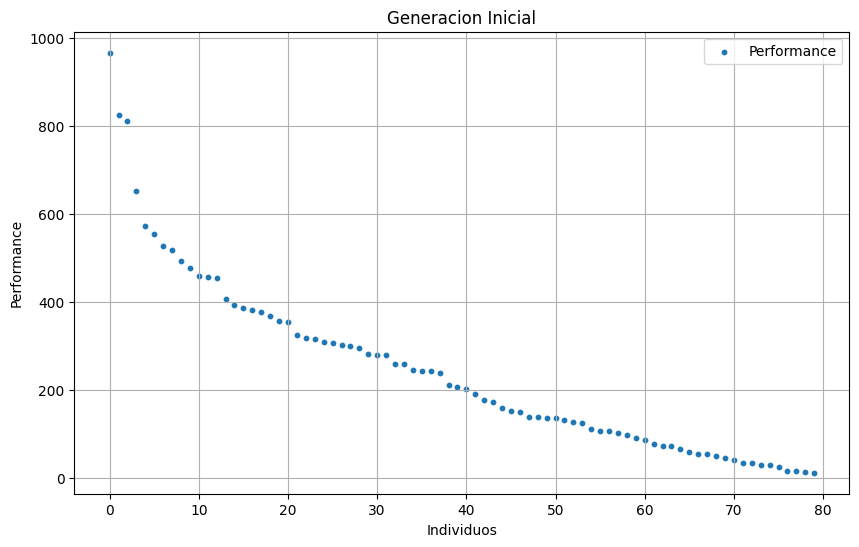

In [20]:
csv = 'generation0.csv'
titulo = 'Generacion Inicial'
graph(csv,titulo)

##### Selections

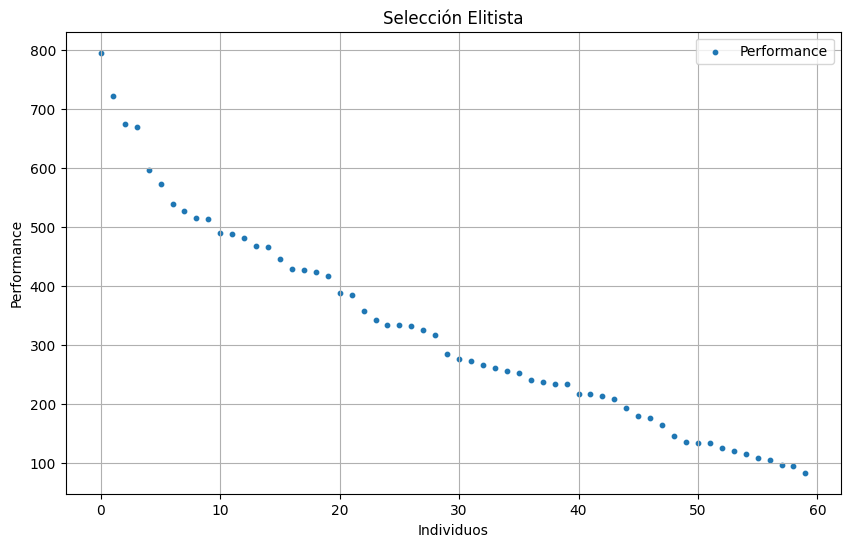

In [21]:
csv = 'elitist_selection.csv'
titulo = 'Selección Elitista'
graph(csv,titulo)

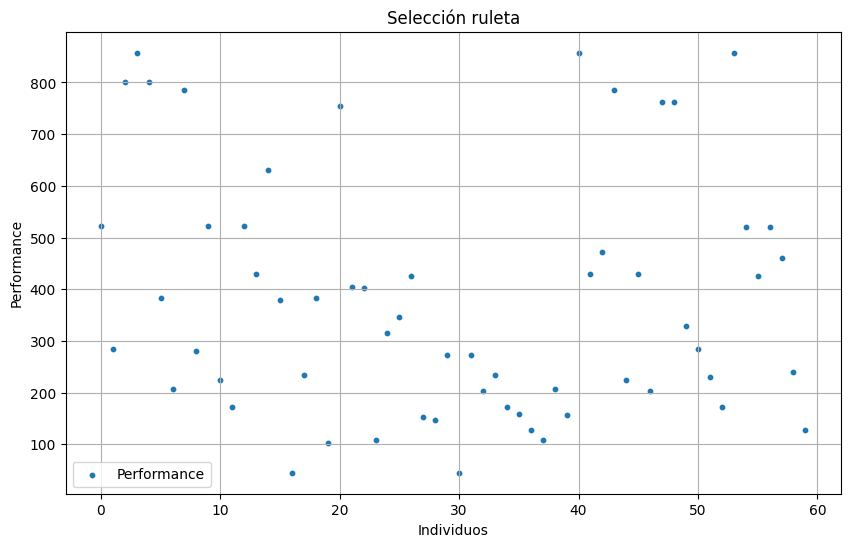

In [22]:
csv = 'roulette_wheel_selection.csv'
titulo = 'Selección ruleta'
graph(csv,titulo)

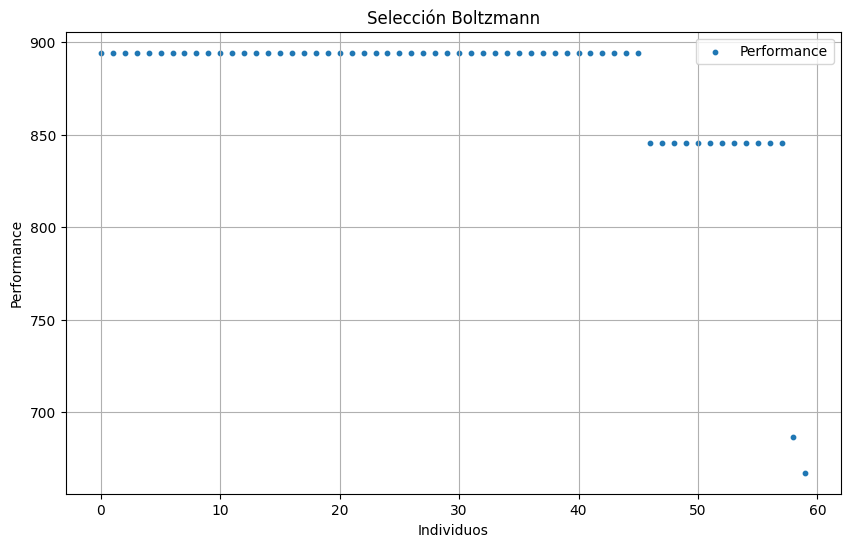

In [23]:
csv = 'boltzmann_selection.csv'
titulo = 'Selección Boltzmann'
graph(csv,titulo)

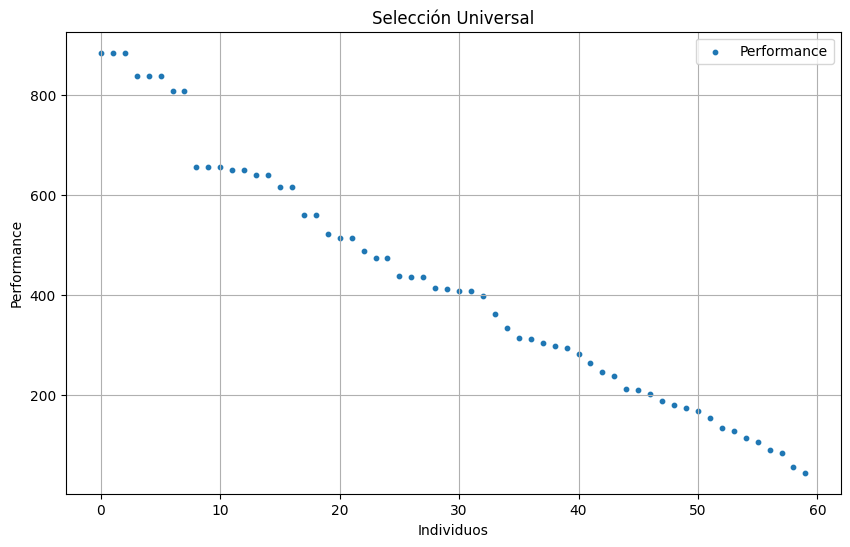

In [24]:
csv = 'universal_selection.csv'
titulo = 'Selección Universal'
graph(csv,titulo)

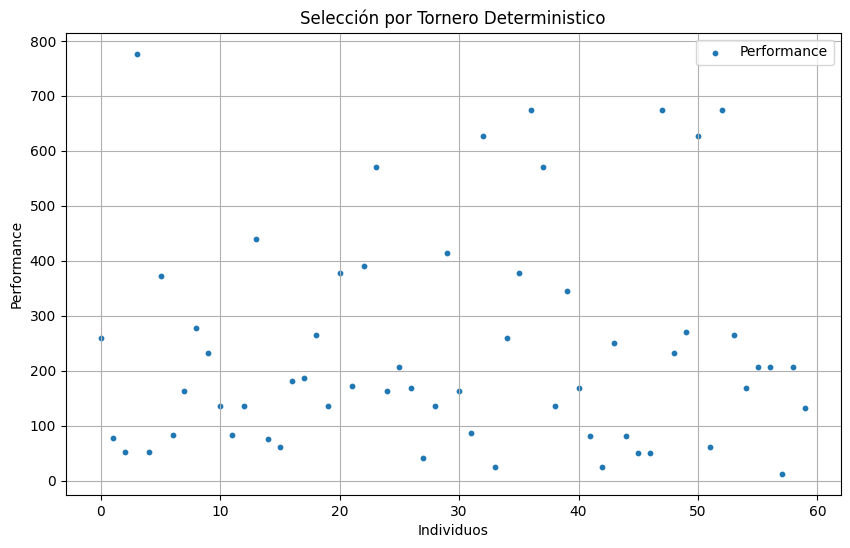

In [25]:
csv = 'deterministic_tournament.csv'
titulo = 'Selección por Tornero Deterministico'
graph(csv,titulo)

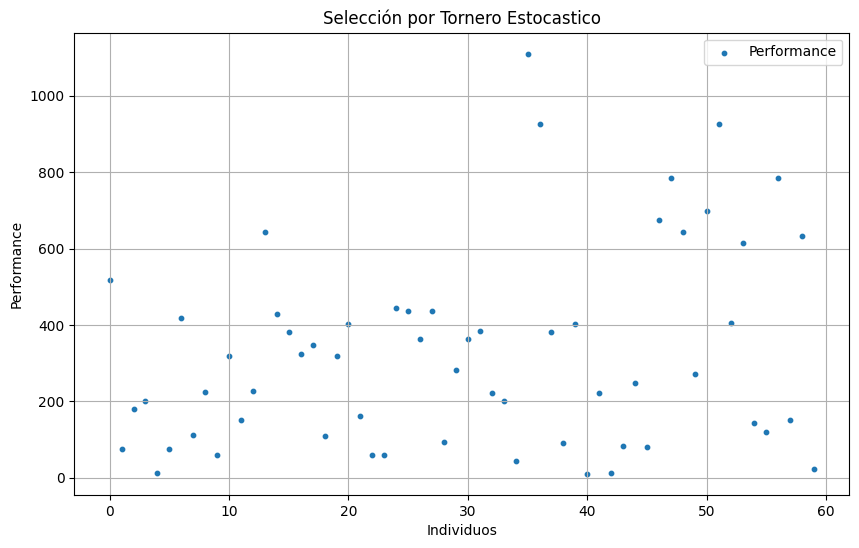

In [26]:
csv = 'stochastic_tournament_selection.csv'
titulo = 'Selección por Tornero Estocastico'
graph(csv,titulo)

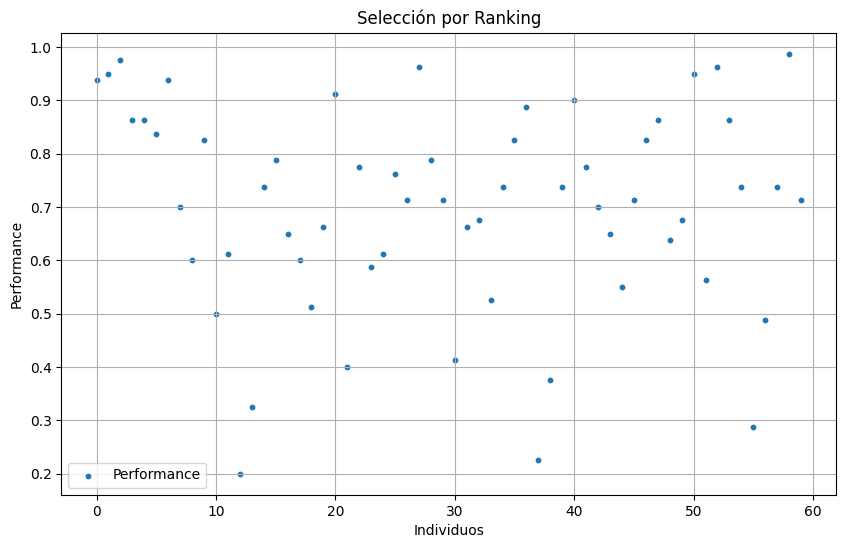

In [27]:
csv = 'rank_based_selection.csv'
titulo = 'Selección por Ranking'
graph(csv,titulo)


##### Crossovers

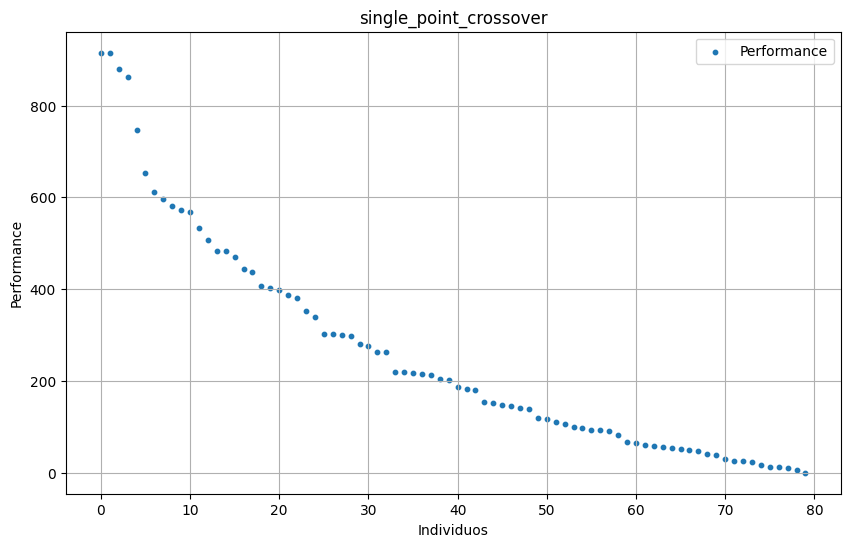

In [28]:
csv = 'single_point_crossover.csv'
titulo = 'single_point_crossover'
graph(csv,titulo)

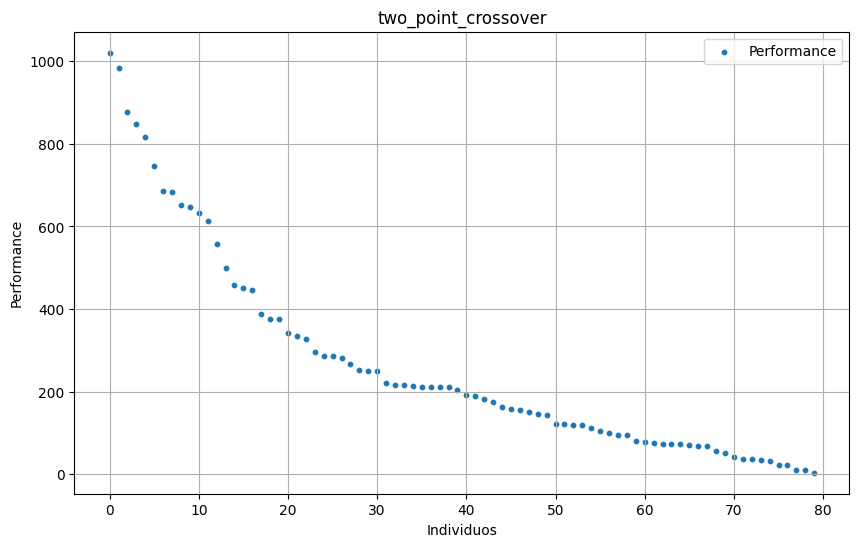

In [29]:
csv = 'two_point_crossover.csv'
titulo = 'two_point_crossover'
graph(csv,titulo)

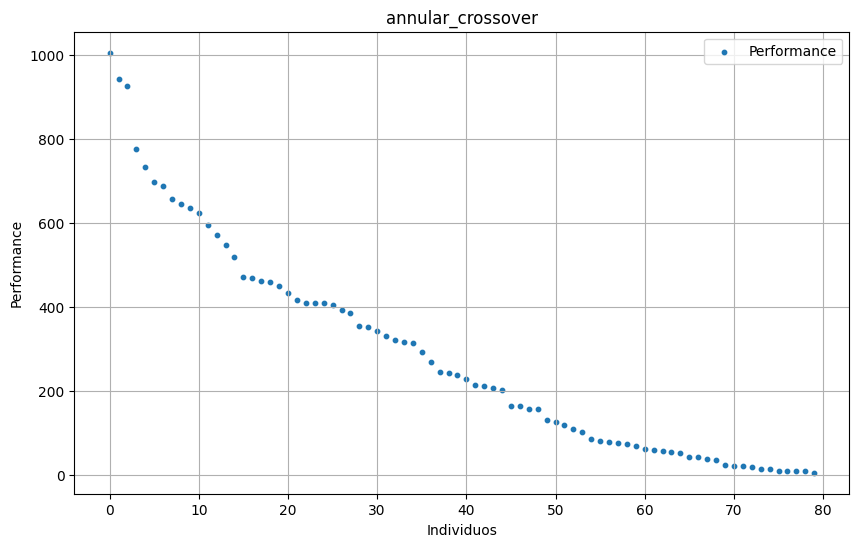

In [30]:
csv = 'annular_crossover.csv'
titulo = 'annular_crossover'
graph(csv,titulo)

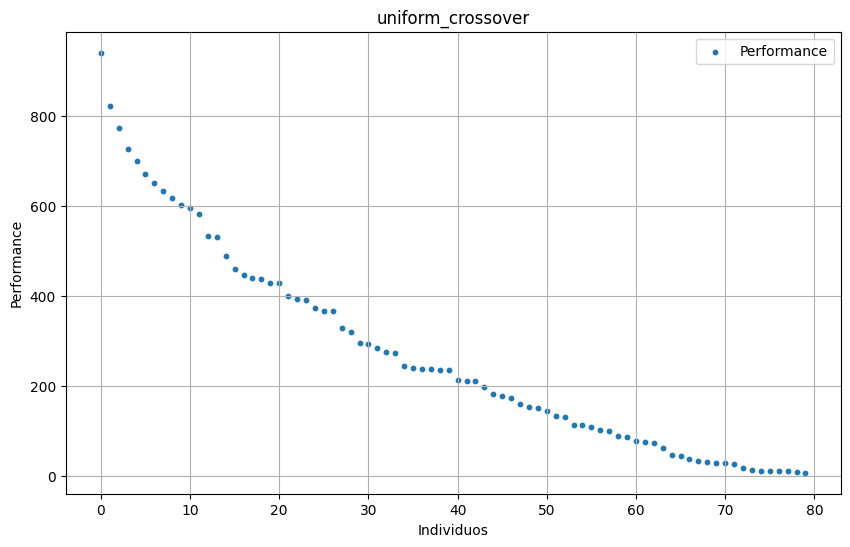

In [31]:
csv = 'uniform_crossover.csv'
titulo = 'uniform_crossover'
graph(csv,titulo)

##### Mutations

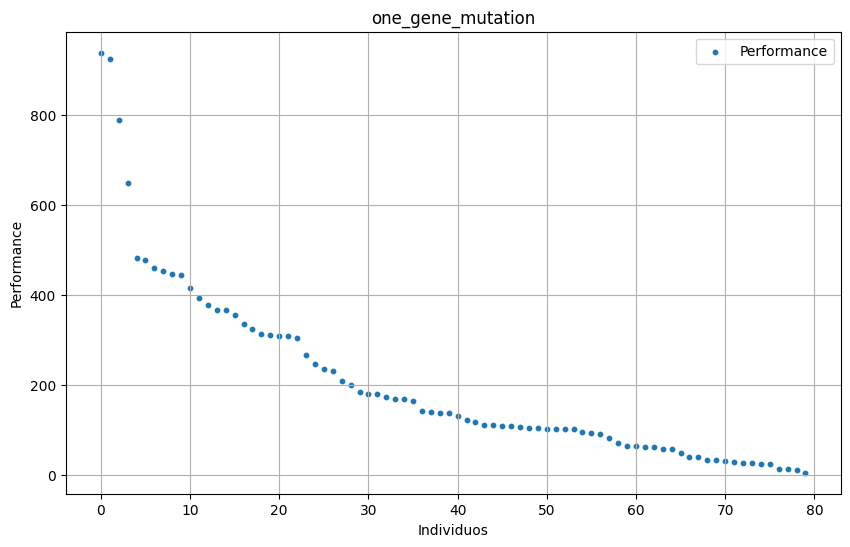

In [32]:
csv = 'one_gene_mutation.csv'
titulo = 'one_gene_mutation'
graph(csv,titulo)

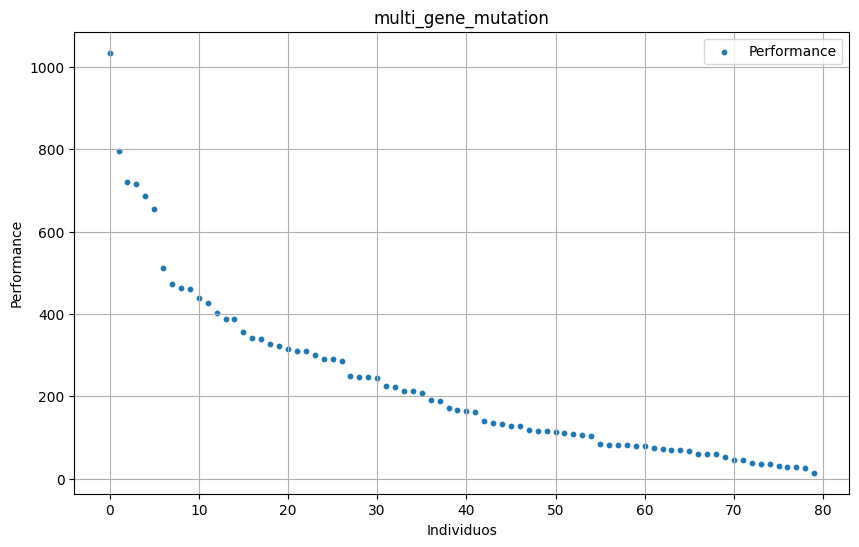

In [33]:
csv = 'multi_gene_mutation.csv'
titulo = 'multi_gene_mutation'
graph(csv,titulo)

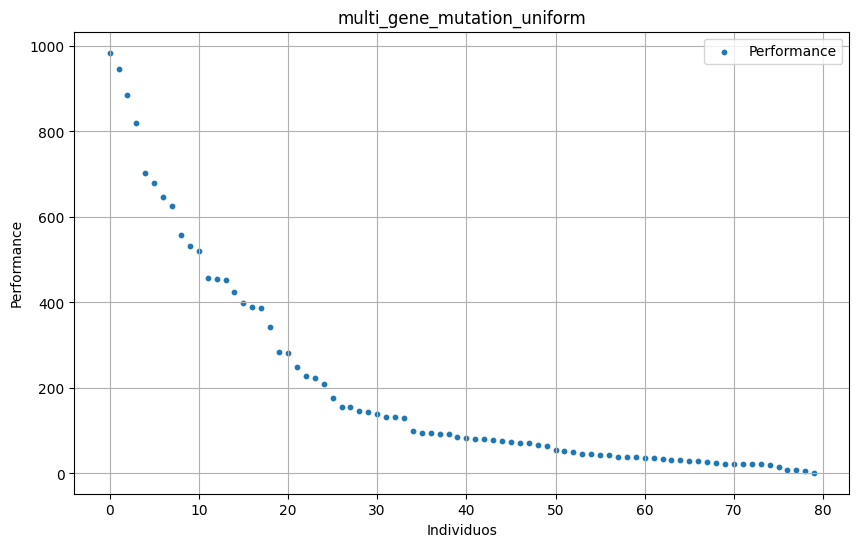

In [34]:
csv = 'multi_gene_mutation_uniform.csv'
titulo = 'multi_gene_mutation_uniform'
graph(csv,titulo)

##### Grafica del Motor AG

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
df = pd.read_csv("datos-Prueba1.csv")

# Encontrar el valor máximo y mínimo de la columna 'performance'
max_performance = df['performance'].max()
min_performance = df['performance'].min()

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(df['generation'], df['performance'], label='Performance', s=3)
plt.scatter(df['generation'].iloc[df['performance'].idxmax()], max_performance, color='red', label='Máximo', s=7)
plt.scatter(df['generation'].iloc[df['performance'].idxmin()], min_performance, color='green', label='Mínimo', s=7)
plt.xlabel('Generación')
plt.ylabel('Performance')
plt.title('Performance por generaciones')
plt.legend()
plt.grid(True)
plt.show()